In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

Download THe Data

In [2]:
train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data',
                           train=False,
                           download=True,
                           transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14595681.52it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 448692.26it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3571804.10it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9789583.13it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
test_data.data.shape, train_data.data.shape

(torch.Size([10000, 28, 28]), torch.Size([60000, 28, 28]))

In [4]:
from torch.utils.data import DataLoader

loaders =  {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

In [5]:
# Defining the model architecture

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)

    return F.softmax(x)



In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [8]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 20 == 0:
      print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} Loss: {loss.item()}')

In [9]:
def test():
  model.eval()

  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct+=pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(loaders['test'].dataset)
  print(f'\nTest set: Average loss: {test_loss}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset)}%)\n')

In [10]:
for epoch in range(1, 11):
  train(epoch)
  test()

<ipython-input-5-8fb1a2765ca0>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 Loss: 2.302436590194702
Train Epoch: 1 [2000/60000 Loss: 2.2977547645568848
Train Epoch: 1 [4000/60000 Loss: 2.202754259109497
Train Epoch: 1 [6000/60000 Loss: 2.0243494510650635
Train Epoch: 1 [8000/60000 Loss: 1.8913447856903076
Train Epoch: 1 [10000/60000 Loss: 1.9135507345199585
Train Epoch: 1 [12000/60000 Loss: 1.7987151145935059
Train Epoch: 1 [14000/60000 Loss: 1.8211174011230469
Train Epoch: 1 [16000/60000 Loss: 1.8177175521850586
Train Epoch: 1 [18000/60000 Loss: 1.7361468076705933
Train Epoch: 1 [20000/60000 Loss: 1.7374186515808105
Train Epoch: 1 [22000/60000 Loss: 1.696853756904602
Train Epoch: 1 [24000/60000 Loss: 1.6461868286132812
Train Epoch: 1 [26000/60000 Loss: 1.6385493278503418
Train Epoch: 1 [28000/60000 Loss: 1.694347858428955
Train Epoch: 1 [30000/60000 Loss: 1.6028286218643188
Train Epoch: 1 [32000/60000 Loss: 1.6661895513534546
Train Epoch: 1 [34000/60000 Loss: 1.6482908725738525
Train Epoch: 1 [36000/60000 Loss: 1.6619980335235596
Train

In [11]:
import matplotlib.pyplot as plt

<ipython-input-5-8fb1a2765ca0>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: tensor([[0]], device='cuda:0')


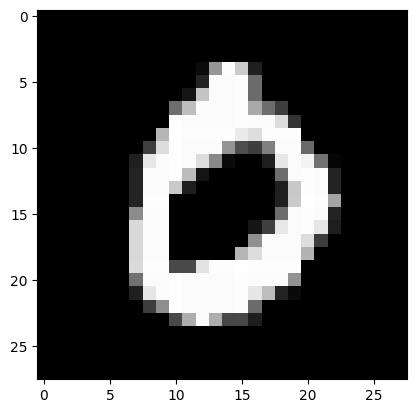

In [14]:
model.eval()
data,target = test_data[3]
data = data.unsqueeze(0).to(device)
output = model(data)

prediction = output.argmax(dim=1, keepdim=True)

print(f'Prediction: {prediction}')
image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()
#